In [109]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import h5py as h5

import re
import astropy.units as u
from scipy.spatial import cKDTree
import matplotlib as mpl
from numba import njit

from scipy.integrate import romberg, quad

time_conv = 977.79222167

In [2]:
sim_list = ['phantom-vacuum-grav', 'phantom-vacuum', 'phantom-Sg10-Rc4.0', 'phantom-vacuum-Sg10-Rc4.0',
            'phantom-vacuum-Sg20-Rc4.0', 'Nbody']

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities'],
              basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = '/n/holyscratch01/hernquist_lab/abeane/starbar_runs/runs/'):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f



In [3]:
sn = read_snap(117, 4, fields=None)

In [113]:
center = np.array([200, 200, 200])
pos = sn.part0.pos - center
dens = sn.part0.rho.value
SFR = sn.part0.sfr

tree = cKDTree(pos)

In [65]:
from cykdtree import PyKDTree
cytree = PyKDTree(pos.value, 
                  left_edge=np.array([-200., -200., -200.]), 
                  right_edge=np.array([200., 200., 200.]), 
                  periodic=np.array([False, False, False]),
                  leafsize=2)

In [66]:
%%timeit
node = cytree.get(np.array([0., 0., 0.]))
out = dens[cytree.idx[node.slice]]

4.63 µs ± 20.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [84]:
node = cytree.get(np.array([0.8, 0., 0.]))
out = dens[cytree.idx[node.slice]]

In [85]:
r = pos.value[cytree.idx[node.slice]]
rmag = np.linalg.norm(r, axis=1)
print(rmag)

[0.85531205]


In [93]:
def rho(z, x, y):
    _, key = tree.query([x, y, z])
    return dens[key]

def cyrho(z, x, y):
    node = cytree.get(np.array([x, y, z]))
    return float(dens[cytree.idx[node.slice]])

In [17]:
%%timeit
_ = rho(0, 0, 0)

42.6 µs ± 81.5 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [95]:
%%timeit
_ = cyrho(0., 0., 0.)

4.84 µs ± 32.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [23]:
from scipy.integrate import quad
ans = quad(rho, -200, 200, args=(0, 0), epsrel=0.01, full_output=1, limit=1024)

In [19]:
%%timeit
ans = quad(rho, -200, 200, args=(0, 0), epsrel=0.01, limit=1024, full_output=1)

82 ms ± 88.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
%%timeit
ans = quad(cyrho, -200, 200, args=(0, 0), epsrel=0.01, limit=1024, full_output=1)

19 ms ± 40.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [116]:
ans = quad(rho, -200, 200, args=(0, 0), epsrel=0.01, limit=1024, full_output=1)
print(ans)

(0.00324698930689493, 2.4989538705390626e-05, {'neval': 1869, 'last': 45, 'iord': array([        29,         25,          1, ..., 1080613504,          0,
       1080619904], dtype=int32), 'alist': array([ 3.66210938e-002, -8.54492188e-002,  1.00000000e+002, ...,
        3.95252517e-323,  0.00000000e+000,  0.00000000e+000]), 'blist': array([ 4.27246094e-002, -7.93457031e-002,  2.00000000e+002, ...,
        2.77170827e-321,  4.65813761e-310,  4.65813761e-310]), 'rlist': array([5.58977124e-005, 1.63302393e-004, 9.21489223e-009, ...,
       5.05923221e-321, 0.00000000e+000, 1.71421511e-318]), 'elist': array([1.23484749e-005, 9.66016115e-006, 1.43634057e-009, ...,
       0.00000000e+000, 1.94167799e-321, 1.98614390e-321])})


In [127]:
ans = romberg(rho, -200, 200, args=(0, 0), divmax=17)

/n/helmod/apps/centos7/Core/Anaconda3/5.0.1-fasrc02/x/lib/python3.6/site-packages/scipy/integrate/quadrature.py:709: AccuracyWarning: divmax (17) exceeded. Latest difference = 5.832190e-05
  AccuracyWarning)


In [126]:
ans

0.003206565486586993

In [5]:
nres = 4096
from numba import njit

@njit
def create_plot_pos(x, y, nres):
    plot_pos = np.zeros((nres*nres, 3))
    for i in range(len(x)):
        for j in range(len(y)):
            plot_pos[i*nres + j][0]=x[i][0]
            plot_pos[i*nres + j][1]=y[0][j]

    return plot_pos

x, y = np.meshgrid(np.linspace(-15, 15, nres), np.linspace(-15, 15, nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)
# print(plot_pos)

In [ ]:
@njit
def create_plot_pos_3D(x, y, z, nres):
    plot_pos = np.zeros((nres*nres*2*nres, 3))
    for i in range(len(x)):
        for j in range(len(y)):
            for k in range(len(z)):
                plot_pos[i*nres + j][0]=x[i][0]
                plot_pos[i*nres + j][1]=y[0][j]

    return plot_pos

In [6]:
%%time
_, key = tree.query(plot_pos)

CPU times: user 27.2 s, sys: 143 ms, total: 27.3 s
Wall time: 27.4 s


In [8]:
plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))

plot_SFR = SFR[key]
plot_SFR_map = np.reshape(plot_SFR, (nres, nres))


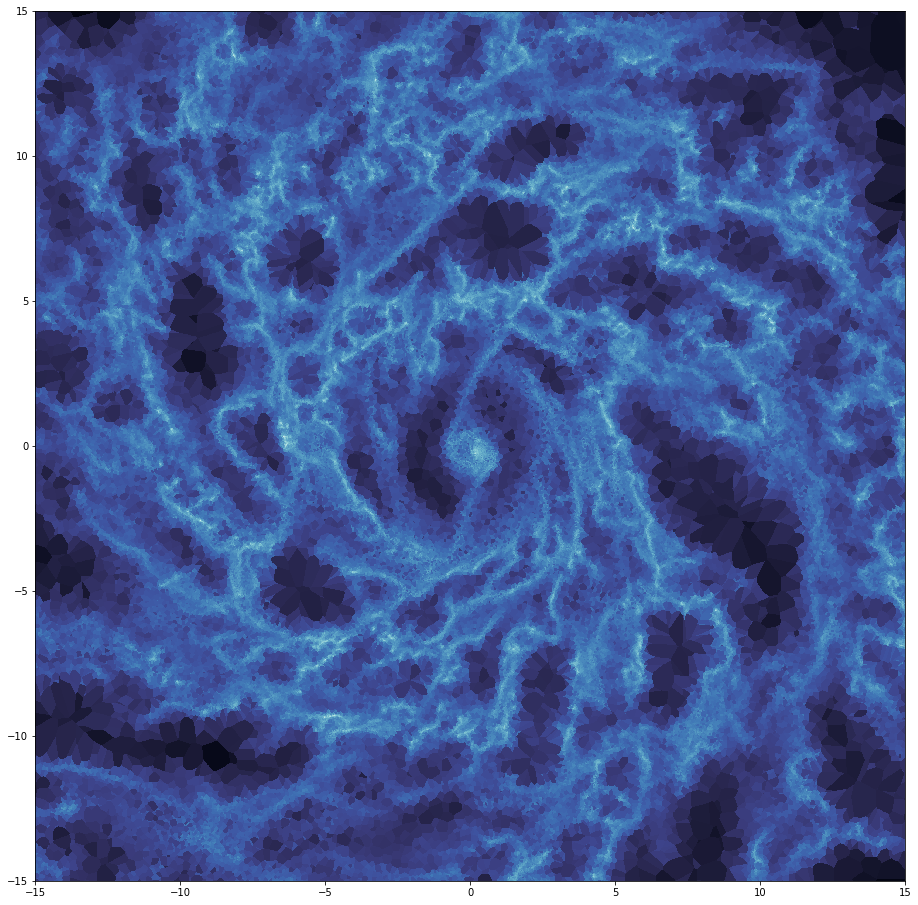

In [20]:


fig, ax = plt.subplots(1, 1, figsize=(16, 16))
extent = [-15, 15, -15, 15]
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap=cmocean.cm.ice)
# ax.imshow(plot_SFR_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds', alpha=1)
plt.show()

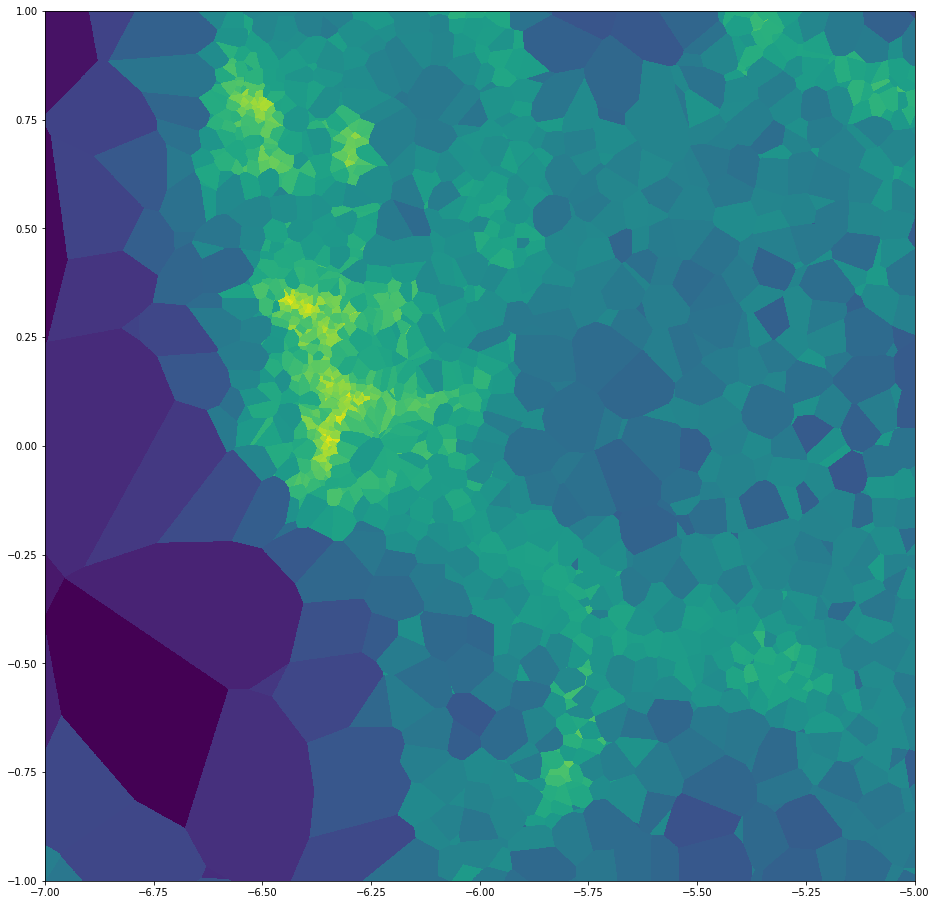

In [22]:
extent = [-7, -5, -1, 1]
nres = 4096

x, y = np.meshgrid(np.linspace(extent[0], extent[1], nres), np.linspace(extent[2], extent[3], nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)
_, key = tree.query(plot_pos)

plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
plt.show()

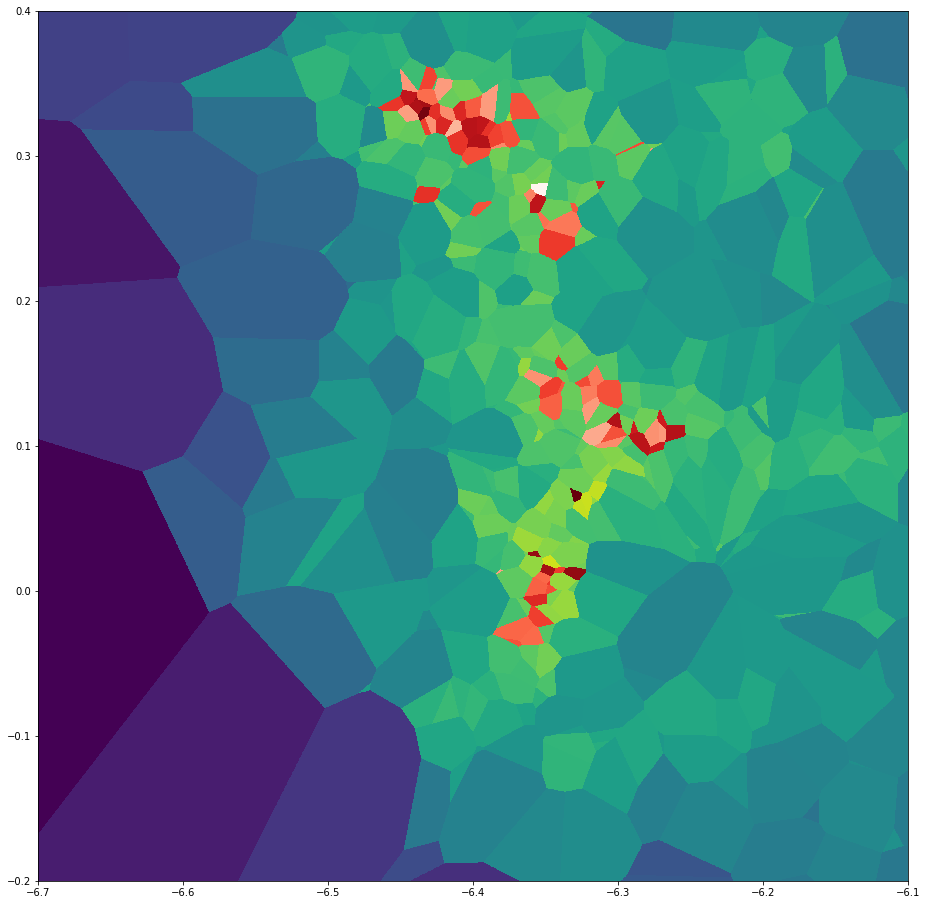

In [23]:
extent = [-6.7, -6.1, -0.2, 0.4]
nres = 4096

x, y = np.meshgrid(np.linspace(extent[0], extent[1], nres), np.linspace(extent[2], extent[3], nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)
_, key = tree.query(plot_pos)

plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))

plot_SFR = SFR[key]
plot_SFR_map = np.reshape(plot_SFR, (nres, nres))

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.imshow(plot_SFR_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm(), cmap='Reds')
plt.show()

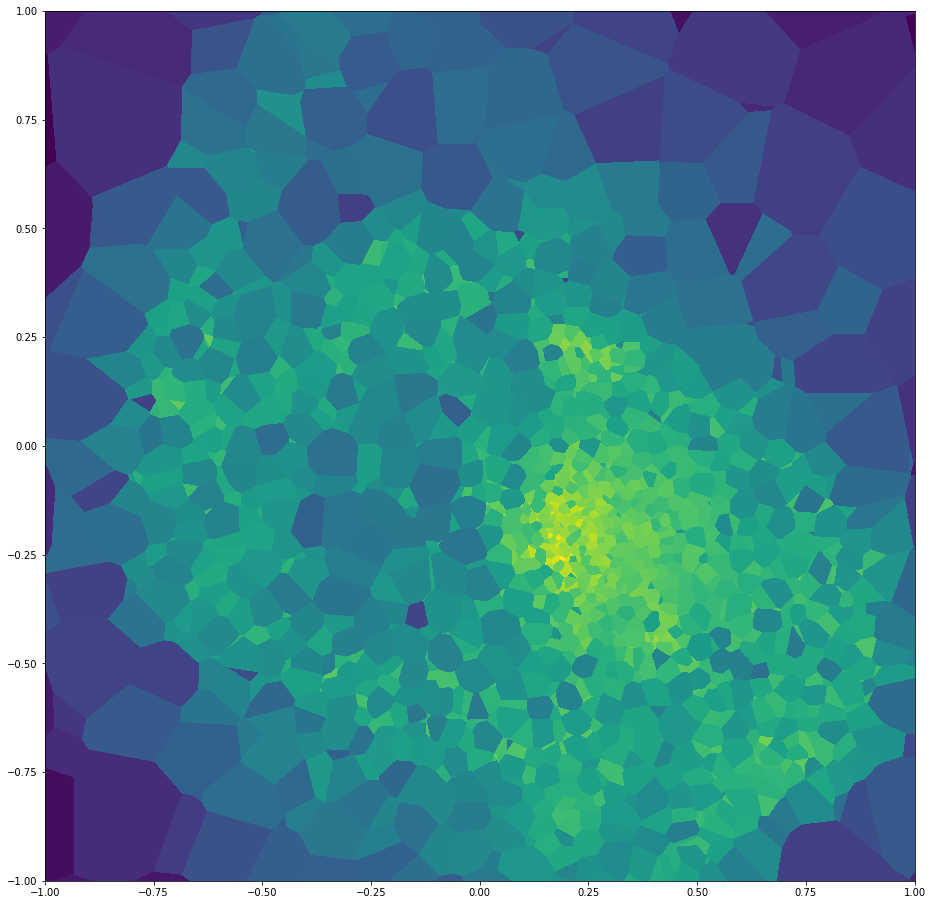

In [66]:
extent = [-1, 1, -1, 1]
nres = 4096

x, y = np.meshgrid(np.linspace(extent[0], extent[1], nres), np.linspace(extent[2], extent[3], nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)
_, key = tree.query(plot_pos)

plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
plt.show()

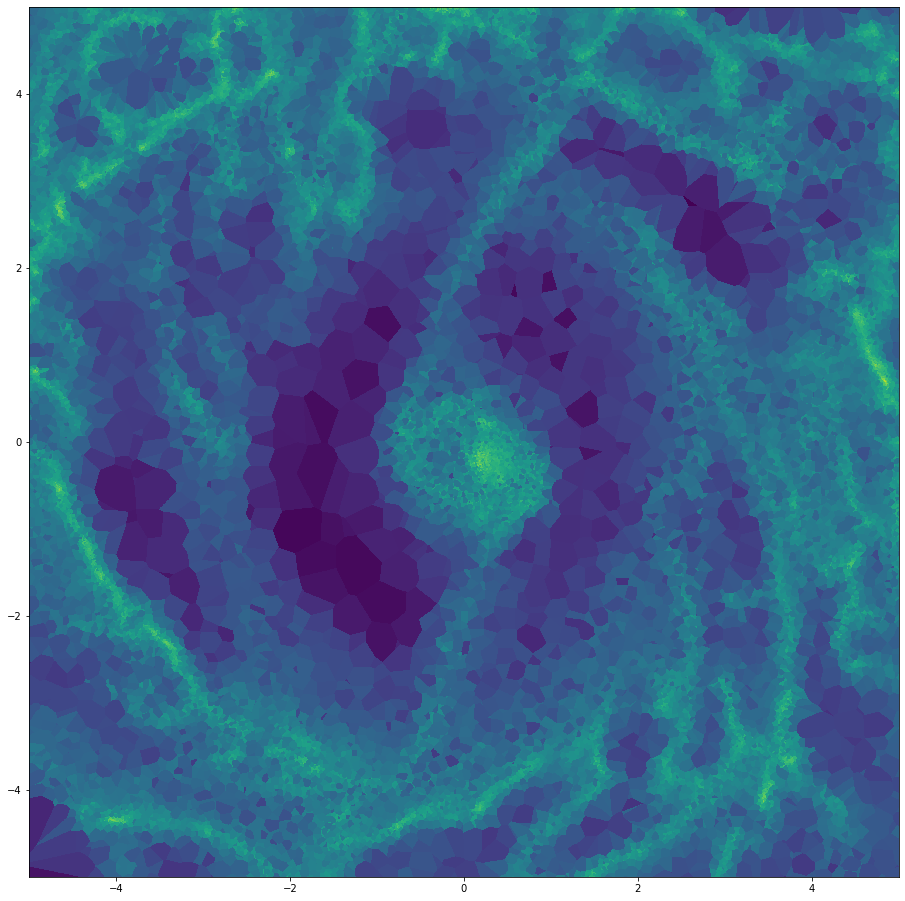

In [67]:
extent = [-5, 5, -5, 5]
nres = 4096

x, y = np.meshgrid(np.linspace(extent[0], extent[1], nres), np.linspace(extent[2], extent[3], nres), indexing='ij')
plot_pos = create_plot_pos(x, y, nres)
_, key = tree.query(plot_pos)

plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres))

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
plt.show()

In [5]:
nres = 256
from numba import njit

zmin = 1E-6
zmax = 200

@njit
def create_plot_pos(x, y, nres):
    plot_pos = np.zeros((nres*nres, 3))
    for i in range(len(x)):
        for j in range(len(y)):
            plot_pos[i*nres + j][0]=x[i][0]
            plot_pos[i*nres + j][1]=y[0][j]

    return plot_pos

xlist = np.linspace(-15, 15, nres)
ylist = np.linspace(-15, 15, nres)
zlist = np.logspace(np.log10(zmin), np.log10(zmax), nres)
zlist = np.concatenate((-zlist, zlist))
zlist = np.sort(zlist)

x, y, z = np.meshgrid(xlist, ylist, zlist, indexing='ij')
plot_pos = create_plot_pos_3D(x, y, z, nres)
# print(plot_pos)

In [4]:
@njit
def create_plot_pos_3D(xlist, ylist, zlist):
    plot_pos = np.zeros((len(xlist)*len(ylist)*len(zlist), 3))

    ct = 0
    for i in range(len(xlist)):
        for j in range(len(ylist)):
            for k in range(len(zlist)):
                plot_pos[ct][0] = xlist[i]
                plot_pos[ct][1] = ylist[j]
                plot_pos[ct][2] = zlist[k]
                ct += 1

    return plot_pos

In [23]:
nres = 64
znres = 32

zmin = 1E-6
zmax = 200

xlist = np.linspace(-15, 15, nres)
ylist = np.linspace(-15, 15, nres)
zlist = np.logspace(np.log10(zmin), np.log10(zmax), znres)
zlist = np.concatenate((-zlist, zlist))
zlist = np.sort(zlist)

print(len(xlist))
print(len(ylist))
print(len(zlist))

plot_pos = create_plot_pos_3D(xlist, ylist, zlist)

# print(plot_pos)

64
64
64


In [28]:
def gen_projection(tree, dens, xmin, xmax, ymin, ymax, zmin, zmax, xnres, ynres, znres):
    xlist = np.linspace(xmin, xmax, xnres)
    ylist = np.linspace(ymin, ymax, ynres)
    
    zlist = np.logspace(np.log10(zmin), np.log10(zmax), znres)
    zlist = np.concatenate((-zlist, zlist))
    zlist = np.sort(zlist)
    
    plot_pos = create_plot_pos_3D(xlist, ylist, zlist)
    
    _, key = tree.query(plot_pos)
    plot_dens = dens[key]
    plot_dens_map = np.reshape(plot_dens, (xnres, ynres, 2*znres))
    
    plot_dens_map = np.trapz(plot_dens_map, zlist)
    
    extent = [xmin, xmax, ymin, ymax]
    
    return extent, plot_dens_map
    

In [42]:
xmin = -15
xmax = 15
ymin = -15
ymax = 15
zmin = 1E-6
zmax = 200
xnres = 64
ynres = 64

dens_map_list = []
for znres in [32, 64, 128, 256, 512, 1024, 2048]:
    extent, dens_map = gen_projection(tree, dens, xmin, xmax, ymin, ymax, zmin, zmax, xnres, ynres, znres)
    
    dens_map_list.append(dens_map)



0.011199480411672591


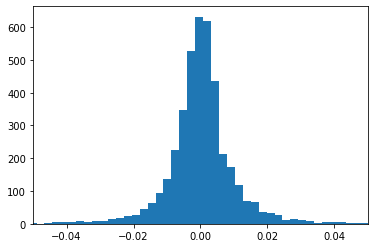

In [46]:
dx = ((dens_map_list[-2] - dens_map_list[-1])/dens_map_list[-1]).ravel()

print(np.std(dx))

plt.hist(dx, bins=100)
plt.xlim(-0.05, 0.05)
plt.show()

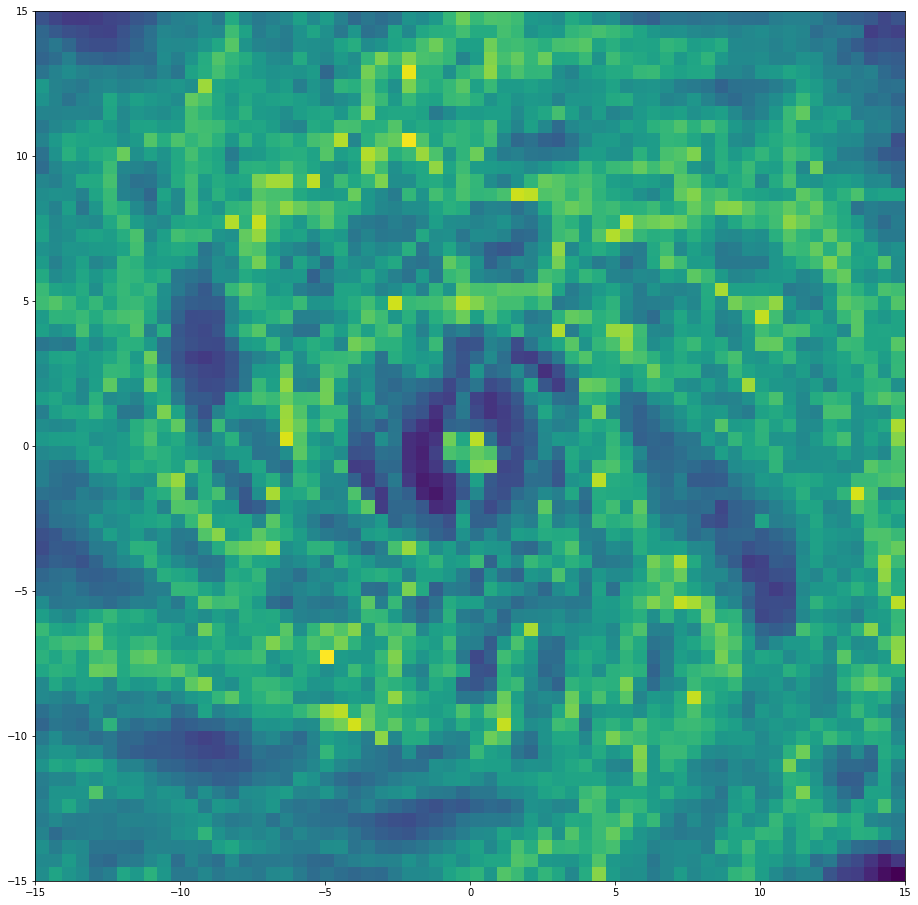

In [27]:
plot_dens = dens[key]
plot_dens_map = np.reshape(plot_dens, (nres, nres, 2*znres))

plot_dens_map = np.trapz(plot_dens_map, zlist)

extent = [-15, 15, -15, 15]

fig, ax = plt.subplots(1, 1, figsize=(16, 16))
ax.imshow(plot_dens_map.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
plt.show()

In [33]:
np.trapz(plot_dens, zlist).shape

(256, 256)

In [10]:
nres = 128
znres = 128

zmin = 1E-6
zmax = 200

xlist = np.linspace(-15, 15, nres)
ylist = np.linspace(-15, 15, nres)
zlist = np.logspace(np.log10(zmin), np.log10(zmax), nres)
zlist = np.concatenate((-zlist, zlist))
zlist = np.sort(zlist)

print(len(xlist))
print(len(ylist))
print(len(zlist))

plot_pos = create_plot_pos_3D(xlist, ylist, zlist)

# print(plot_pos)

128
128
256


In [12]:
%%time
_, key = tree.query(plot_pos)

CPU times: user 6.97 s, sys: 71.8 ms, total: 7.04 s
Wall time: 7.05 s


In [15]:
center = np.array([200, 200, 200])
pos = sn.part0.pos - center
dens = sn.part0.rho
SFR = sn.part0.sfr

pos.value

array([[-59.02667557,  75.88046594, 181.25072498],
       [-80.20967424, 103.53424004, 184.26090407],
       [-64.71456464, 102.1884186 , 180.10525352],
       ...,
       [ 25.61480081, -71.24997268,  26.44019122],
       [ 39.63063752, -60.20989579,  22.81309181],
       [ 42.98896367, -62.76281752,  37.90718862]])

In [16]:
from sklearn.neighbors import NearestNeighbors

In [17]:
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(pos.value)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=1, p=2, radius=1.0)

In [19]:
%%time
key = neigh.kneighbors(plot_pos, 1, return_distance=False)

CPU times: user 15.6 s, sys: 106 ms, total: 15.7 s
Wall time: 15.7 s


In [21]:
key.shape

(4194304, 1)